In [1]:
#!/usr/bin/env python

import math
import healpy as hp
import numpy as np
import sys
import time
import os
sys.path.insert(1, '../../../PySSC/')

from classy import Class
import PySSC
from scipy.stats import norm
from matplotlib import pyplot as plt

from numcosmo_py import Ncm, Nc

Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

In [2]:
cosmo_resample = Nc.HICosmoDEXcdm()
reion_resample = Nc.HIReionCamb.new()
prim_resample = Nc.HIPrimPowerLaw.new()
cosmo_resample.omega_x2omega_k()

cosmo_resample.param_set_by_name ("H0", 67.81)
cosmo_resample.param_set_by_name ("Omegac", 0.2612)
cosmo_resample.param_set_by_name ("Omegab", 0.0486)
cosmo_resample.param_set_by_name ("w", -1.0)
cosmo_resample.param_set_by_name ("Omegak", 0.0)

cosmo_resample.add_submodel(reion_resample)
cosmo_resample.add_submodel(prim_resample)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-8)
psml.require_kmax(1.0e6)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
prim_resample.props.n_SA = 0.9660


z_obs = Ncm.Vector.new_array(np.linspace(0.1, 0.8, 8))
lnM_obs = Ncm.Vector.new_array(np.linspace(np.log(10) * 14.0, np.log(10) * 15, 2))

print(z_obs.dup_array())
print(lnM_obs.dup_array())

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8]
[32.23619130191664, 34.53877639491069]


# Construct the $S_{ij}$  Matrix

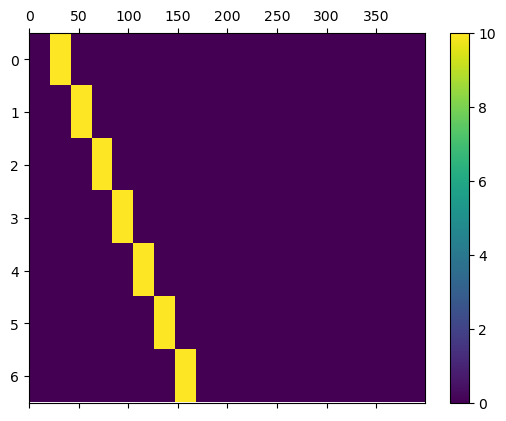

In [3]:
nz = 400
z_arr = np.linspace(0, 1.9, num=nz + 1)[1:]

nbins_T = z_obs.len() - 1

kernels_T = np.zeros((nbins_T, nz))
for i in range(nbins_T):
    zminbin = z_obs.get(i)
    zmaxbin = z_obs.get(i + 1)
    Dz = zmaxbin - zminbin

    for iz in range(nz):
        z = z_arr[iz]
        if (z > zminbin) and (z <= zmaxbin):
            kernels_T[i, iz] = 1 / Dz

fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.matshow(kernels_T)
ax.set_aspect("auto")
plt.colorbar(im)
pass

In [4]:
NSIDE = 2 * 512
NPIX = hp.nside2npix(NSIDE)
m = np.zeros(hp.nside2npix(NSIDE))
pix_theta_ecl, pix_phi_ecl = hp.pix2ang(NSIDE, np.arange(NPIX))

# Guaranteed mask
mask1_guaranteed = np.zeros(NPIX)
mask2_guaranteed = np.zeros(NPIX)
mask3_guaranteed = np.zeros(NPIX)

mask1_guaranteed_condition = (
    (pix_phi_ecl > 3.0 * np.pi / 4.0)
    & (pix_phi_ecl < 13.0 * np.pi / 12.0)
    & (pix_theta_ecl < np.pi / 2.0 - 30.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_guaranteed_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)
mask3_guaranteed_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0 - 20.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 40.0 * np.pi / 180)
)

mask1_guaranteed[mask1_guaranteed_condition] = 1
mask2_guaranteed[mask2_guaranteed_condition] = 1
mask3_guaranteed[mask3_guaranteed_condition] = 1

mask_guaranteed = mask1_guaranteed + mask2_guaranteed + mask3_guaranteed

# Total mask
mask1_full = np.zeros(NPIX)
mask2_full = np.zeros(NPIX)
mask3_full = np.zeros(NPIX)

mask1_full_condition = (
    (pix_phi_ecl > 2.0 * np.pi / 3.0)
    & (pix_phi_ecl < 3.0 * np.pi / 2.0)
    & (pix_theta_ecl < np.pi / 2.0 - 10.0 * np.pi / 180)
    & (pix_theta_ecl > np.pi / 2.0 - 80.0 * np.pi / 180)
)
mask2_full_condition = (
    (pix_phi_ecl > 11.0 * np.pi / 6.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)
mask3_full_condition = (
    (pix_phi_ecl < np.pi / 4.0)
    & (pix_theta_ecl < np.pi / 2.0)
    & (pix_theta_ecl > np.pi / 2.0 - 45.0 * np.pi / 180)
)

mask1_full[mask1_full_condition] = 1
mask2_full[mask2_full_condition] = 1
mask3_full[mask3_full_condition] = 1

mask_full = mask1_full + mask2_full + mask3_full

`S matrix `

In [5]:
cosmo_sij = Nc.HICosmoDEXcdm()
cosmo_sij.omega_x2omega_k()

cosmo_sij.param_set_by_name ("H0", 67.81)
cosmo_sij.param_set_by_name ("Omegac", 0.2612)
cosmo_sij.param_set_by_name ("Omegab", 0.0486)
cosmo_sij.param_set_by_name ("w", -1.0)
cosmo_sij.param_set_by_name ("Omegak", 0.0)

reion_sij = Nc.HIReionCamb.new()
prim_sij = Nc.HIPrimPowerLaw.new()

prim_sij.props.ln10e10ASA = 3.027449698161606

cosmo_sij.add_submodel(reion_sij)
cosmo_sij.add_submodel(prim_sij)

# Full sky
t0 = time.time()
S_lacasa_full = PySSC.Sij(z_arr, kernels_T, cosmo_Class=cosmo_sij)
t1 = time.time()
print("Full sky time (seconds) = " + str(t1 - t0))

S_fit = Ncm.Matrix.new(S_lacasa_full.shape[0], S_lacasa_full.shape[1])
for i in range(len(S_lacasa_full)):
    for j in range(len(S_lacasa_full[i])):
        S_fit.set(i, j, S_lacasa_full[i][j])


S_fit.log_vals("Sij: ", "% 22.15g")

Full sky time (seconds) = 0.34113407135009766
Sij:    1.92175205877645e-05  -3.03940429181774e-06  -6.13267746083644e-07  -1.98416530133711e-07  -9.01835132135309e-08  -3.50713697574375e-08  -1.62884212049099e-08
Sij:   -3.03940429181774e-06   7.41146312478369e-06  -1.31034891678634e-06  -3.46504158861848e-07  -1.18176054912998e-07  -5.17946097934648e-08  -2.92215648127833e-08
Sij:   -6.13267746083644e-07  -1.31034891678634e-06   3.72376949794711e-06   -7.0167046785694e-07  -2.29473536237457e-07  -7.73712907142391e-08  -3.69163500312817e-08
Sij:   -1.98416530133711e-07  -3.46504158861848e-07   -7.0167046785694e-07   2.39727654957993e-06  -4.80727998063613e-07  -1.57265044361002e-07  -5.98165060549361e-08
Sij:   -9.01835132135309e-08  -1.18176054912998e-07  -2.29473536237457e-07  -4.80727998063613e-07    1.5828634357491e-06  -3.29998435362026e-07    -1.218551539022e-07
Sij:   -3.50713697574375e-08  -5.17946097934648e-08  -7.73712907142391e-08  -1.57265044361002e-07  -3.29998435362026e-0

# Define proxy modelling

In [6]:
cluster_m = Nc.ClusterMassNodist(lnM_min=np.log(10) * 14.0, lnM_max=np.log(10) * 16 )
cluster_z = Nc.ClusterRedshiftNodist(z_min=0.0, z_max=2.0)

# Initialize the `ClusterAbundance` object

In [7]:
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200.0)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hbias_Tinker = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, hbias_Tinker)
cad.prepare(cosmo_resample, cluster_z, cluster_m)
guaranteed_area = 2959.1
cad.set_area(guaranteed_area * (np.pi / 180) ** 2)

# Data model

$f(x_i)$ for the Gaussian distribution $$-2\ln L = \sum_{ij}\left[(f(x_i) - y_i)C^{-1}_{ij}(f(x_j) - y_j)\right] + \dots$$

In [8]:
mset_sij = Ncm.MSet.new_array([cosmo_sij,cluster_m,cluster_z])
ser = Ncm.Serialize.new(Ncm.SerializeOpt.NONE)

ncounts_gauss = Nc.DataClusterNCountsGauss.new(cad)
ncounts_gauss.set_size((z_obs.len()-1)*(lnM_obs.len()-1))
ncounts_gauss.set_init(True)
ncounts_gauss.set_fix_cov(False)
ncounts_gauss.use_norma(True)
ncounts_gauss.set_z_obs(z_obs)
ncounts_gauss.set_lnM_obs(lnM_obs)
ncounts_gauss.set_has_ssc(True)
rng = Ncm.RNG.seeded_new (None, 42)

# Creating the fit object and calculating the MC

In [ ]:
#preparing the resample model

parameters = [[0.8,4.9, 0.1] , [0.8,4.9,-4.9] , [0.8,2.1,0.1] , [0.1,4.9,0.1] , [0.8,2.1,-4.9] , [0.1,4.9,-4.9] , [0.1,2.1,0.1] , [0.1,2.1,-4.9]]

for case in parameters:
    cosmo_resample.param_set_by_name("w", case[2])
    cosmo_resample.param_set_by_name("Omegac", case[0])
    prim_resample.param_set_by_name("ln10e10ASA", case[1])

    mset_resample = Ncm.MSet.new_array([cosmo_resample,cluster_m,cluster_z])

    print("MCMC w = %.2f, omegac = %.2f, ln10e10ASA = %.2f  in a area of  %.1f deg²" % (cosmo_resample.props.w ,cosmo_resample.props.Omegac, prim_resample.props.ln10e10ASA, guaranteed_area))

    S_lacasa_full = PySSC.Sij(z_arr, kernels_T, cosmo_Class=cosmo_resample)
    S_resample = Ncm.Matrix.new(S_lacasa_full.shape[0], S_lacasa_full.shape[1])
    for i in range(len(S_lacasa_full)):
        for j in range(len(S_lacasa_full[i])):
            S_resample.set(i, j, S_lacasa_full[i][j])

    ncounts_gauss.set_s_matrix(S_fit)
    ncounts_gauss.set_resample_s_matrix(S_resample)

    ncounts_gauss.get_resample_s_matrix().log_vals("Sij_resample: ", "% 22.15g")
    print("\n")
    ncounts_gauss.get_s_matrix().log_vals("Sij_fit: ", "% 22.15g")

    ncounts_gauss.resample(mset_resample, rng)
    ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)

    dset = Ncm.Dataset.new()
    dset.append_data(ncounts_gauss)


    cosmo_sij.props.Omegac_fit = True
    cosmo_sij.props.Omegab_fit = False
    cosmo_sij.props.w_fit = True
    prim_sij.props.ln10e10ASA_fit = True
    mfunc_oa = Ncm.ObjArray.new()
    mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
    mfunc_oa.add(mfunc_sigma8)
    print(mfunc_sigma8.eval0(mset_resample))


    mset_fit = mset_sij.dup(ser)
    mset_fit.prepare_fparam_map()

    mset_fit.pretty_log()
    mset_resample.pretty_log()
        
    lh = Ncm.Likelihood.new(dset)

    fit = Ncm.Fit.new(
        Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_fit, Ncm.FitGradType.NUMDIFF_FORWARD
    )

    init_sampler = Ncm.MSetTransKernGauss.new(0)
    init_sampler.set_mset(mset_fit)
    init_sampler.set_prior_from_mset()
    init_sampler.set_cov_from_rescale(1.0)  # 1

    sampler = "apes"

    nwalkers = int(math.ceil(500))  # 500
    ssize = 400000  # 1000000

    walker = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset_fit.fparams_len())

    esmcmc = Ncm.FitESMCMC.new_funcs_array(
        fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa
    )

    esmcmc.set_data_file("mcmc_%.2f,%.2f,%.2f.fits" % (cosmo_resample.props.w ,cosmo_resample.props.Omegac, prim_resample.props.ln10e10ASA))

    esmcmc.set_nthreads(4)
    t0 = time.time()
    esmcmc.start_run()
    esmcmc.run(ssize / nwalkers)
    # esmcmc.run (10)
    # esmcmc.run_lre (50, 1.0e-3)
    esmcmc.end_run()
    t1 = time.time()

    esmcmc.mean_covar()

    print("MCMC correct version." )

    ncounts_gauss.set_s_matrix(S_resample)

    ncounts_gauss.get_resample_s_matrix().log_vals("Sij_resample: ", "% 22.15g")
    print("\n")
    ncounts_gauss.get_s_matrix().log_vals("Sij_fit: ", "% 22.15g")

    ncounts_gauss.peek_mean().log_vals("y: ", "%.3f", True)

    dset = Ncm.Dataset.new()
    dset.append_data(ncounts_gauss)

    cosmo_sij.props.Omegac_fit = True
    cosmo_sij.props.Omegab_fit = False
    cosmo_sij.props.w_fit = True
    prim_sij.props.ln10e10ASA_fit = True
    mfunc_oa = Ncm.ObjArray.new()
    mfunc_sigma8 = Ncm.MSetFuncList.new("NcHICosmo:sigma8", psf)
    mfunc_oa.add(mfunc_sigma8)
    print(mfunc_sigma8.eval0(mset_resample))

    mset_fit = mset_sij.dup(ser)
    mset_fit.prepare_fparam_map()
    mset_fit.pretty_log()
    mset_resample.pretty_log()

    lh = Ncm.Likelihood.new(dset)

    fit = Ncm.Fit.new(
        Ncm.FitType.NLOPT, "ln-neldermead", lh, mset_fit, Ncm.FitGradType.NUMDIFF_FORWARD
    )

    init_sampler = Ncm.MSetTransKernGauss.new(0)
    init_sampler.set_mset(mset_fit)
    init_sampler.set_prior_from_mset()
    init_sampler.set_cov_from_rescale(1.0)  # 1

    sampler = "apes"

    nwalkers = int(math.ceil(500))  # 500
    ssize = 200000  # 1000000

    walker = Ncm.FitESMCMCWalkerAPES.new(nwalkers, mset_fit.fparams_len())

    esmcmc = Ncm.FitESMCMC.new_funcs_array(
        fit, nwalkers, init_sampler, walker, Ncm.FitRunMsgs.SIMPLE, mfunc_oa
    )

    esmcmc.set_data_file("mcmc_%.2f,%.2f,%.2f_correct.fits" % (cosmo_resample.props.w ,cosmo_resample.props.Omegac, prim_resample.props.ln10e10ASA))

    esmcmc.set_nthreads(4)
    t0 = time.time()
    esmcmc.start_run()
    esmcmc.run(ssize / nwalkers)
    # esmcmc.run (10)
    # esmcmc.run_lre (50, 1.0e-3)
    esmcmc.end_run()
    t1 = time.time()

    esmcmc.mean_covar()

MCMC w = -4.50, omegac = 0.70, ln10e10ASA = 2.50  in a area of  2959.1 deg²
Sij_resample:    8.34261209706909e-06  -1.24649705363446e-06  -1.73753105182808e-07  -2.97173407510564e-08  -6.57963681693218e-09  -1.37287946927585e-08  -1.59926236604932e-08
Sij_resample:   -1.24649705363446e-06   3.12860996163074e-06  -5.49143513812213e-07  -7.01170032356958e-08  -2.19519217275244e-08  -2.05699784968494e-08   1.30622058241525e-08
Sij_resample:   -1.73753105182808e-07  -5.49143513812213e-07   1.66460433595467e-06  -2.84490528792749e-07  -5.29585736316912e-08  -1.76140288662292e-08  -1.07151411787732e-08
Sij_resample:   -2.97173407510564e-08  -7.01170032356958e-08  -2.84490528792749e-07   1.05763209023867e-06  -2.27909823357733e-07  -4.01238099561009e-08  -2.30794355690962e-08
Sij_resample:   -6.57963681693218e-09  -2.19519217275244e-08  -5.29585736316912e-08  -2.27909823357733e-07   6.40041772944136e-07  -1.70987436123079e-07  -3.51405694805275e-08
Sij_resample:   -1.37287946927585e-08  -2.05